# Import Libraries

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [129]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load Data

In [130]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/E Commerce Dataset.xlsx', sheet_name='E Comm')

# Handling Duplicated Data

In [131]:
df.duplicated().sum()

0

In [132]:
df.isna().sum()

CustomerID                       0
Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

# Handling Missing Values

Karena semua kolom yang missing value merupakan kolom numerik, maka missing value-nya dapat kita isi dengan nilai median. Alasan memilih nilai median karena semua kolom ini memiliki distribusi yang right skewed, sehingga nilai yang lebih representatif adalah median dibandingkan mean.

In [133]:
cols = ['Tenure', 'WarehouseToHome', 'HourSpendOnApp', 'OrderAmountHikeFromlastYear',
        'CouponUsed', 'OrderCount', 'DaySinceLastOrder']

for col in cols:
  df[col] = df[col].fillna(df[col].median())
df.isna().sum()

CustomerID                     0
Churn                          0
Tenure                         0
PreferredLoginDevice           0
CityTier                       0
WarehouseToHome                0
PreferredPaymentMode           0
Gender                         0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
PreferedOrderCat               0
SatisfactionScore              0
MaritalStatus                  0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

# Recategorize Inconsistent Value in Categorical Features

In [134]:
df = df.replace(['Mobile','Phone','CC','COD'],['Mobile Phone','Mobile Phone','Credit Card','Cash on Delivery'])

In [135]:
cats = df.select_dtypes(exclude=['number', 'datetime']).columns.tolist()

for col in cats:
  unique = df[col].unique()
  nunique = df[col].nunique()
  print(col,'- total:',nunique)
  print(unique)
  print('='*50,'\n')

PreferredLoginDevice - total: 2
['Mobile Phone' 'Computer']

PreferredPaymentMode - total: 5
['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']

Gender - total: 2
['Female' 'Male']

PreferedOrderCat - total: 5
['Laptop & Accessory' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']

MaritalStatus - total: 3
['Single' 'Divorced' 'Married']



Berdasarkan hasil di atas, dapat kita lihat bahwa kita sudah berhasil meng-handle semua value yang tidak konsisten.

# Feature Transformation

Saya memilih melakukan transformasi data terlebih dulu sebelum melakukan handling outlier. Tujuannya sederhana, yaitu agar data terdistribusi normal dulu sehingga saat handling outlier tidak banyak data yang dibuang karena terindikasi sebagai outlier.

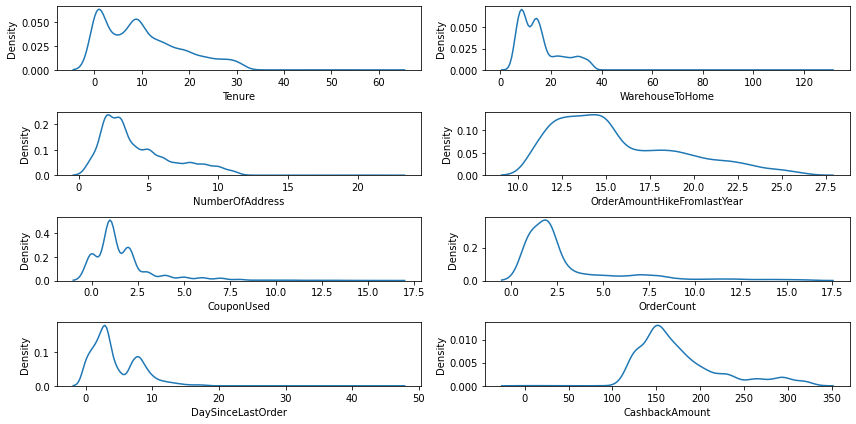

In [136]:
from sklearn.preprocessing import PowerTransformer

cols = ['Tenure', 'WarehouseToHome', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
        'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

# KDE Before Transform
plt.figure(figsize=(12, 6))
for i in range(len(cols)):
  plt.subplot(4, 2, i+1)
  sns.kdeplot(data=df, x=df[cols[i]])
  plt.tight_layout()

In [137]:
for col in cols:
  pt = PowerTransformer()
  df[col] = pt.fit_transform(df[col].values.reshape(len(df), 1))
  print('Skew value:', df[col].skew())

Skew value: -0.1325992079859532
Skew value: 0.04785379148414715
Skew value: 0.02839756667138825
Skew value: 0.08217398296654219
Skew value: 0.005103453417964467
Skew value: 0.22430140046319771
Skew value: -0.03294403835927981
Skew value: 0.2649612892350135


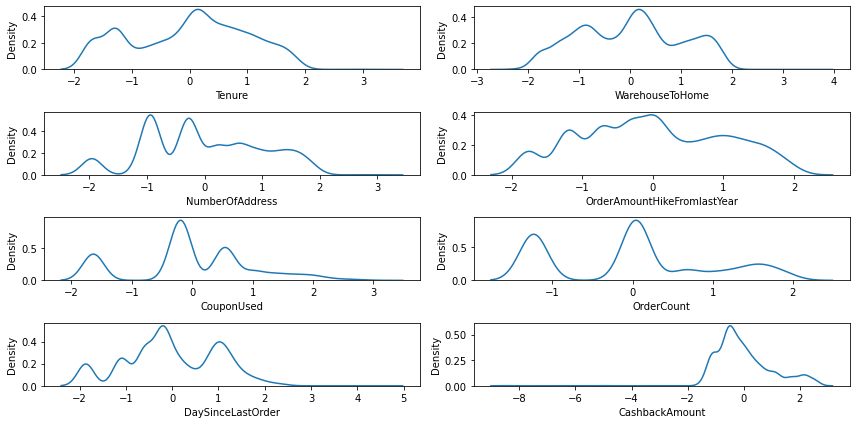

In [138]:
# KDE setelah Transform
plt.figure(figsize=(12, 6))
for i in range(len(cols)):
  plt.subplot(4, 2, i+1)
  sns.kdeplot(data=df, x=df[cols[i]])
  plt.tight_layout()

# Handling Outlier

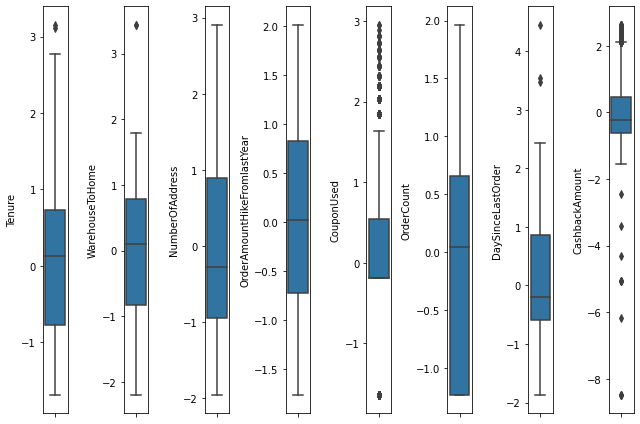

In [139]:
# Boxplot sebelum handling outlier
cols = ['Tenure', 'WarehouseToHome', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
        'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
        
plt.figure(figsize=(9,6))
for i in range(len(cols)):
    plt.subplot(1, len(cols), i+1)
    sns.boxplot(y = df[cols[i]], orient = 'v')
    plt.tight_layout()

In [140]:
# Handling outlier dengan z-score
cols = ['Tenure', 'WarehouseToHome', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
        'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']

rows_before_filt = len(df)
print('Jumlah Baris sebelum filter:', rows_before_filt, '\n')



filtered_entries = np.array([True] * len(df))

for col in cols:
    zscore = abs(stats.zscore(df[col]))                       # hitung absolute z-scorenya
    filtered_entries = (zscore < 3) & filtered_entries        # keep yang kurang dari 3 absolute z-scorenya
    
df = df[filtered_entries]                                     # filter, cuma ambil yang z-scorenya dibawah 3

# Total baris yang dibuang
rows_after_filt = len(df)
diff = round((rows_before_filt - rows_after_filt) / rows_before_filt * 100, 2)
print(f'Jumlah baris setelah memfilter outlier: {len(df)}')
print(f'Persentase outlier yang dibuang:', diff)

Jumlah Baris sebelum filter: 5630 

Jumlah baris setelah memfilter outlier: 5612
Persentase outlier yang dibuang: 0.32


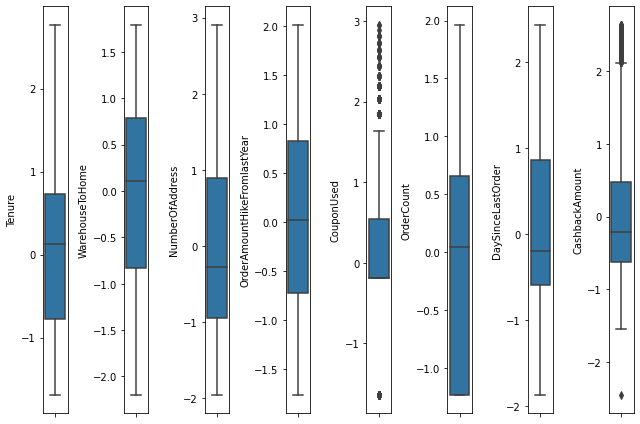

In [141]:
# Boxplot setelah handling outlier
cols = ['Tenure', 'WarehouseToHome', 'NumberOfAddress', 'OrderAmountHikeFromlastYear',
        'CouponUsed', 'OrderCount', 'DaySinceLastOrder', 'CashbackAmount']
        
plt.figure(figsize=(9,6))
for i in range(len(cols)):
    plt.subplot(1, len(cols), i+1)
    sns.boxplot(y = df[cols[i]], orient = 'v')
    plt.tight_layout()

Di atas adalah boxplot dari setiap feature yang telah dilakukan handling outlier menggunakan metode z-score. Terlihat bahwa outlier dari beberapa kolom telah di-drop. Akan tetapi, pada kolom CoupenUsed dan CashbackAmount masih terdapat indikasi outlier dan data ini akan tetap kita gunakan dalam modeling. 

# Feature Selection

In [142]:
df.columns

Index(['CustomerID', 'Churn', 'Tenure', 'PreferredLoginDevice', 'CityTier',
       'WarehouseToHome', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp',
       'NumberOfDeviceRegistered', 'PreferedOrderCat', 'SatisfactionScore',
       'MaritalStatus', 'NumberOfAddress', 'Complain',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount',
       'DaySinceLastOrder', 'CashbackAmount'],
      dtype='object')

In [143]:
selected = ['Tenure', 'CityTier', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore',
            'Complain', 'DaySinceLastOrder', 'CashbackAmount', 'NumberOfAddress',
            'PreferredLoginDevice', 'Gender', 'PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus',
            'Churn'
            ]
df = df[selected]

# Feature Encoding

## Label Encoding <br>
Saya akan melakukan label encoding pada kolom PreferredLoginDevice dan Gender. Hal ini karena keduanya memiliki unique value yang hanya sejumlah 2.

In [144]:
# Label encoding  
mapping_login_device = {
    'Mobile Phone' : 0,
    'Computer' : 1}

df['PreferredLoginDevice'] = df['PreferredLoginDevice'].map(mapping_login_device)


mapping_gender ={
    'Female':0,
    'Male':1}
df['Gender'] = df['Gender'].map(mapping_gender)

## One Hot Encoding

In [145]:
cols_OHE = ['PreferredPaymentMode', 'PreferedOrderCat', 'MaritalStatus']

for i in cols_OHE:
    onehots = pd.get_dummies(df[i], prefix=i, drop_first=True)  # drop_first=True utk menghindari multicollinearity
    df = df.join(onehots)

# kolom yang telah dilakukan OHE akan di-drop
df = df.drop(columns=cols_OHE)

In [146]:
# total columns
df.shape[1]

22

# Train-Test Split Data

In [147]:
# Split Dataset
from sklearn.model_selection import train_test_split
training_data, testing_data = train_test_split(df, test_size=0.2, random_state=100)

print('Total training data:', training_data.shape[0])
print('Total testing data :', testing_data.shape[0])

Total training data: 4489
Total testing data : 1123


In [148]:
# Splitting data
X_train = training_data.drop(columns=['Churn'])
y_train =  training_data['Churn']

X_test = testing_data.drop(columns=['Churn'])
y_test = testing_data['Churn']

X = X_train

In [149]:
# Standarisasi Features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform (X_test)

# Modeling

In [150]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [159]:
# Fungsi Evaluasi Model
def eval(model):
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    from sklearn.metrics import precision_score, recall_score, roc_auc_score
    print('roc-auc (train):', round(roc_auc_score(y_train, y_pred_train), 2))
    print('recall (train):', round(recall_score(y_train, y_pred_train), 2))
    print("="*35)
    print('roc-auc (test):', round(roc_auc_score(y_test, y_pred_test), 2))
    print('recall (test):', round(recall_score(y_test, y_pred_test), 2))  


def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    ax = feat_importances.nlargest(10).plot(kind='barh', figsize=(10, 8), color='green', edgecolor='black')
    ax.set_facecolor("#F5F5F5")
    
    ax.invert_yaxis()
    
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)

    plt.xlabel('Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance', fontsize=15, fontweight='bold')

In [152]:
etr = ExtraTreesClassifier()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rf = RandomForestClassifier(random_state = 100)
gbc = GradientBoostingClassifier()
xgb = XGBClassifier(random_state = 100, use_label_encoder=False)
ada = AdaBoostClassifier(random_state = 100)
cat = CatBoostClassifier(random_state = 100, verbose = False)

models = [dt, knn, svc, rf, gbc, xgb, ada, cat, etr]

names = ['Decision Tree',
         'KNN',
         'SVM',
       'Random Forest',
       'Gradient Boosting',
       'XGBoost',
       'AdaBoost',
       'CatBoost',
       'Extra Tree Classifier']

## Default Hyperparameter

In [153]:
for i, name in zip(models, names):
  print(name)
  model = i
  model.fit(X_train, y_train)
  eval(model)
  print('\n')

Decision Tree
roc-auc (train): 1.0
recall (train): 1.0
roc-auc (test): 0.92
recall (test): 0.86


KNN
roc-auc (train): 0.94
recall (train): 0.9
roc-auc (test): 0.83
recall (test): 0.68


SVM
roc-auc (train): 0.85
recall (train): 0.7
roc-auc (test): 0.82
recall (test): 0.66


Random Forest
roc-auc (train): 1.0
recall (train): 1.0
roc-auc (test): 0.95
recall (test): 0.91


Gradient Boosting
roc-auc (train): 0.83
recall (train): 0.68
roc-auc (test): 0.8
recall (test): 0.64


XGBoost
roc-auc (train): 0.81
recall (train): 0.65
roc-auc (test): 0.78
recall (test): 0.6


AdaBoost
roc-auc (train): 0.78
recall (train): 0.58
roc-auc (test): 0.76
recall (test): 0.56


CatBoost
roc-auc (train): 0.98
recall (train): 0.95
roc-auc (test): 0.92
recall (test): 0.85


Extra Tree Classifier
roc-auc (train): 1.0
recall (train): 1.0
roc-auc (test): 0.95
recall (test): 0.9




3 model terbaik adalah RandomForest, DecisionTree, dan CatBoost

# Hyperparamater Tuning

## Random Forest

In [154]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# List Hyperparameters yang akan diuji
hyperparameters = dict(
                       n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)], # Jumlah subtree 
                       bootstrap = [True], # Apakah pakai bootstrapping atau tidak
                       criterion = ['gini','entropy'],
                       max_depth = [int(x) for x in np.linspace(10, 110, num = 11)],  # Maximum kedalaman tree
                       min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 10, num = 5)], # Jumlah minimum samples pada node agar boleh di split menjadi leaf baru
                       min_samples_leaf = [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)], # Jumlah minimum samples pada leaf agar boleh terbentuk leaf baru
                       max_features = ['auto', 'sqrt', 'log2'], # Jumlah feature yg dipertimbangkan pada masing-masing split
                       n_jobs = [-1], # Core untuk parallel computation. -1 untuk menggunakan semua core
                      )

# Init
rf = RandomForestClassifier(random_state=100)
rf_tuned = RandomizedSearchCV(rf, hyperparameters, cv=5, random_state=100, scoring='recall')
rf_tuned.fit(X_train,y_train)

# Predict & Evaluation
eval(rf_tuned)

roc-auc (train): 1.0
recall (train): 1.0
roc-auc (test): 0.93
recall (test): 0.86


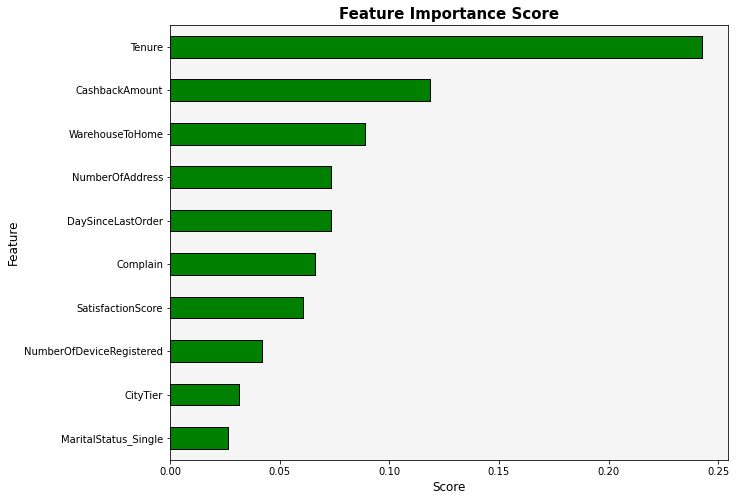

In [155]:
show_feature_importance(rf_tuned.best_estimator_)

## Decision Tree

In [156]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
import numpy as np

# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features
                      )

# Inisialisasi Model
dt = DecisionTreeClassifier(random_state=100)
dt_tuned = RandomizedSearchCV(dt, hyperparameters, cv=5, random_state=100, scoring='recall')
dt_tuned.fit(X_train, y_train)

# Predict & Evaluation
eval(dt_tuned)

roc-auc (train): 1.0
recall (train): 1.0
roc-auc (test): 0.91
recall (test): 0.86


## Extra Tree Classifier

In [157]:
hyperparameters = {'n_estimators': [5, 10, 15, 20,50,100],
          'max_depth': [None, 2,5,7, 10, 13, 15, 25],
          'min_samples_split': [0.5, 1, 3, 5, 7, 10],
          'min_samples_leaf': [1, 0.5, 3, 5, 7, 10],
          'max_features': [None, 'sqrt', 'auto', 'log2'],
          'bootstrap':[True, False]
         }


etr = ExtraTreesClassifier(random_state=100)
etr_tuned = RandomizedSearchCV(etr, hyperparameters, cv=5, random_state=100, scoring='recall')
etr_tuned.fit(X_train, y_train)

y_pred_test_etr_tuned = etr_tuned.predict(X_test)

roc-auc (train): 1.0
recall (train): 1.0
roc-auc (test): 0.96
recall (test): 0.94


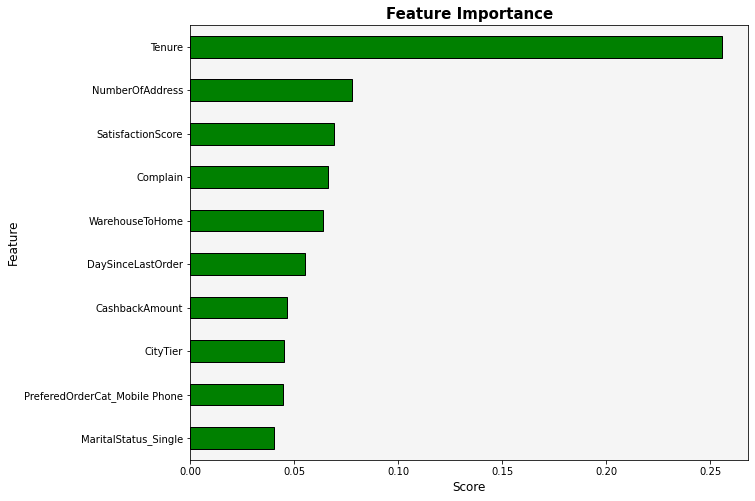

In [160]:
show_feature_importance(etr_tuned.best_estimator_)

In [161]:
y_pred_test_etr_tuned = etr_tuned.predict(X_test)

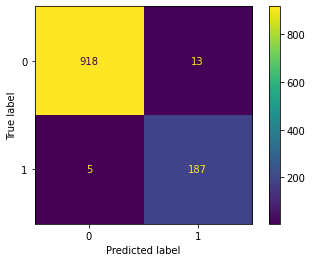

In [165]:
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay

cm = confusion_matrix(y_pred_test_etr_tuned, y_test, labels= etr_tuned.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= etr_tuned.classes_)
disp.plot()
plt.show()